In [9]:
import numpy as np
import pandas as pd
import os
import random
from pathlib import Path as pt
import torch
import torchaudio
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio import transforms
from torchvision.transforms import v2
# from Moduls.MosreDataset import MosreDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

DEVICE = torch.device("cuda")

MAIN = pt(os.getcwd())
DATASET_PATCH = MAIN / 'morse_dataset'
AUDIO_FILES = DATASET_PATCH / 'morse_dataset'

# Поятоянные значения выявленные в процессе анализа
MORSEALP = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
MAX_TIME = 48
SAMPLE_RATE = 8000
N_MELS = 128
N_FFT = 400
HOP_LENGTH = 180
TOP_DB = 80
FREQ_MASK = 30
TIME_MASK = 40

# Гиперпараметы обучения
SEED = 42
BATCH_SIZE = 16
EPOCHS = 20
LEARNING_RATE = 0.002 #2e-4
WEIGHT_DECAY = 0.00001
# int_to_alph = dict(enumerate(MORSEALP))
# alph_to_int = {char:enum for enum, char in int_to_alph.items()}

#===== Import data =====
train_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'train.csv'))
test_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'test.csv'))
sample_data = pd.read_csv(pt.joinpath(DATASET_PATCH,'sample_submission.csv'))



In [10]:
class MosreDataset(Dataset):
    """
    Класс для обработки 
    """
    def __init__(self, df, data_patch, train=True, transforms=None, prev_chars = 1):
        self.df = df
        self.is_train = train

        self.data_path = data_patch
        self.audio_paths = self.data_path / 'morse_dataset'

        self.transforms = transforms

        self.morse_alp = "АБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ 1234567890#"
        self.int_to_alph = dict(enumerate(MORSEALP, start=1)) # 0 - Выводим под пустое
        self.alph_to_int = {char:enum+1 for enum, char in self.int_to_alph.items()}
        self.prev_chars = prev_chars

        if self.is_train:
            self.messeges = self.df.message.values

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        #Получение аугментрованых спектрограмм
        try:
            audio_file = self.audio_paths / self.df.id.values[index]
            waveform, sample_rate = torchaudio.load(audio_file)
            augmented_spectrogram = self.transforms(waveform)

            if self.is_train:
                message = self.messeges[index]
                #Получение списка индексов секта - как требует CTC los
                '''
                При обработке dataloader labels будут выравниваться по макс длине для выравнивания батча
                Т.е. будет padding 0. что в будующем будет пустым значением для ctc loss
                '''
                label = torch.LongTensor([self.morse_alp.find(c) + 1 for c in message])
                label_len = torch.LongTensor([len(label)])
                return augmented_spectrogram, label, label_len
            else:
                return augmented_spectrogram
        except Exception as ex:
            print(str(ex))
        
    def change_time(self, audio_file, max_len = 384000):
        waveform, sample_rate = torchaudio.load(audio_file)
        cahanal, sig_len = waveform.shape

        if sig_len < max_len:
            pad_len = torch.zeros(max_len - sig_len).unsqueeze(0)
            waveform = torch.cat([waveform, pad_len], dim=1)

        return waveform

# Загрузка датасета

In [19]:
train_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    transforms.FrequencyMasking(freq_mask_param=FREQ_MASK),
    transforms.TimeMasking(time_mask_param=TIME_MASK),
    v2.RandomCrop((N_MELS, 320)) # Обрезает последний кадр спектрограммы, в идеале надобы считать а не прописывать число
    ) # заметка - Данные трансформации не создают довых обучаемых параметров. Но есть и те что создают. В будущем это стоит учитывать

valid_audio_transforms = nn.Sequential(
    transforms.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=N_FFT, n_mels=N_MELS),
    transforms.AmplitudeToDB(top_db=TOP_DB),
    v2.RandomCrop((N_MELS, 320)) 
    )

train_dataframe, val_dataframe = train_test_split(train_data, test_size=0.15, random_state=SEED)

train_ds = MosreDataset(df=train_dataframe,
                        data_patch=DATASET_PATCH,
                        train=True,
                        transforms=train_audio_transforms)

val_ds = MosreDataset(df=val_dataframe,
                        data_patch=DATASET_PATCH,
                        train=True,
                        transforms=valid_audio_transforms)

def my_collate(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.nn.utils.rnn.pad_sequence(
                                            [item[1] for item in batch], 
                                            batch_first=True, 
                                            padding_value=0) # выравнивает последовательность до макс 
                                                            # длины в датче заполняя пропуски нулем
    label_len = torch.stack([item[2] for item in batch])
    return [data, target, label_len]

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, collate_fn=my_collate)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=my_collate)
test = next(iter(train_dl))[0].to(DEVICE)
test.shape

torch.Size([16, 1, 128, 320])

Вывод - torch.Size([32, 1, 128, 1921]) => нужно обрезать посдлелний кадр в спектрограмме 1921 -> 1920(torchvision.transformes.RandomCrop). Или подобрать Гиперпараметры(не вышло)

# Класс модели

In [20]:
FIRST_FE_COUNT = 16
SECOND_FE_COUNT = 32
THIRD_FE_COUNT = 32
QAD_FE_COUNT = 32
PADDING = 'same'
MAXPOOL_KERNEL = 2
KERTNEL_SIZE = 3
NERON_COUNT = 128
GRU_HIDEN = 256
# Start with 4 transforms
class MorseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=FIRST_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(FIRST_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAXPOOL_KERNEL), # [batch, FIRST_FE_COUNT = 16, 64, 960]

            nn.Conv2d(in_channels=FIRST_FE_COUNT, 
                      out_channels=SECOND_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(SECOND_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAXPOOL_KERNEL), # [batch, SECOND_FE_COUNT = 32, 32, 480]

            nn.Conv2d(in_channels=SECOND_FE_COUNT, 
                      out_channels=THIRD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(THIRD_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=MAXPOOL_KERNEL), # [batch, THIRD_FE_COUNT = 32, 16, 240]

            nn.Conv2d(in_channels=THIRD_FE_COUNT, 
                      out_channels=QAD_FE_COUNT, 
                      kernel_size=KERTNEL_SIZE , stride=1, padding=PADDING),
            nn.BatchNorm2d(QAD_FE_COUNT),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,3)), # [batch=32, QAD_FE_COUNT = 32, 8, 80](что юы сохраниить большще признаков по горизонтали)
        )

        self.rnn1 = nn.GRU(input_size=N_MELS*2,hidden_size=GRU_HIDEN, num_layers=3, bidirectional=True)

        # self.faltten = nn.Flatten() # [32, 81920]
        # self.layer1 = nn.Linear(81920, N_MELS, bias=False)         
        # self.layer2 = nn.Linear(N_MELS, len(MORSEALP), bias=False)         

    def forward(self, x):
        x = self.net_conv(x)

        batch, channels, reduced_mels, reduced_time = x.shape
        x = x.permute(0, 3, 1, 2)  # [batch, time, channels, mels]
        # В частности, каждый вектор признаков в последовательности признаков генерируется 
        # слева направо на картах признаков. Это означает, что i-й вектор признаков представляет 
        # собой объединение столбцов всех карт. 
        # Таким образом, форма тензора может быть изменена, например, на (размер_пакета, 80, 256)
        x = x.reshape(batch, reduced_time, -1)  # to GRU [batch=32, seq_len=80, features=256]

        x = self.rnn1(x)
        x, _ = x # берем информацию со всез состояний
        x = x.log_softmax(dim=2) 
        # x = self.faltten(x)

        # x = self.layer1(x)
        # x = self.layer2(x)
        return x

Переменные для обучения.

In [21]:
model = MorseNet().to(DEVICE)
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
loss_func = nn.CTCLoss()

In [23]:
model(test).shape

torch.Size([16, 13, 512])

# Обучение модели

0) Сохдать отдельный трансформер на валинацию => Изменить class Dataset 
1) Обучить на 1-м батче
2) изменить LEARNING_RATE и WEIGHT_DECAY 

3) попробовать убрать выравнивание по длинне аудио - появляется много пустого места => модет плохо сказываться на обучение

In [24]:
lst_loss_train = []
lst_loss_val = []

for epoch in range(EPOCHS):
    model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    train_tqdm = tqdm(train_dl, desc=f"Эпоха {epoch+1}/{EPOCHS} [Обучение]", leave=False)
    for mel_spec, labels, label_lens in train_tqdm:
        mel_spec, labels, label_lens = mel_spec.to(DEVICE), labels.to(DEVICE), label_lens.to(DEVICE)

        #===== считатем длинну mel_spec для передачи в CTC loss =====
        
        predict = model(mel_spec) # (N=batch,T,C)
        permuted_predict = predict.permute(1, 0, 2)
        N = predict.shape[0]
        T = predict.shape[1]
        predict_lengths = torch.full(size=(N,), fill_value=T, dtype=torch.long)

        # print(permuted_predict.shape, labels.shape, predict_lengths.shape, label_lens.shape)
        # break
        loss = loss_func(permuted_predict, labels, predict_lengths, label_lens)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()
        train_loss = epoch_train_loss / len(train_data)


    # ======== Валидация ========
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for val_mel_spec, val_labels, val_label_lensin in tqdm(
                                                        val_dl, 
                                                        desc=f"Эпоха {epoch+1}/{EPOCHS} [Валидация]", 
                                                        leave=False):
            val_mel_spec, val_labels, val_label_lensin = val_mel_spec.to(DEVICE), val_labels.to(DEVICE), val_label_lensin.to(DEVICE)
            val_predict = model(val_mel_spec)

            permuted_val_predict = val_predict.permute(1, 0, 2)
            val_N = val_predict.shape[0]
            val_T = val_predict.shape[1]
            predict_val_lengths = torch.full(size=(val_N,), fill_value=val_T, dtype=torch.long)
            val_loss += loss_func(permuted_val_predict, val_labels, predict_val_lengths, val_label_lensin).item()



    lst_loss_train.append(train_loss)
    lst_loss_val.append(val_loss)

            
    print(f"\nЭпоха {epoch+1}/{EPOCHS}")
    # print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print("-" * 50)


Эпоха 1/20
Train Loss: nan
Val Loss: nan
--------------------------------------------------


KeyboardInterrupt: 

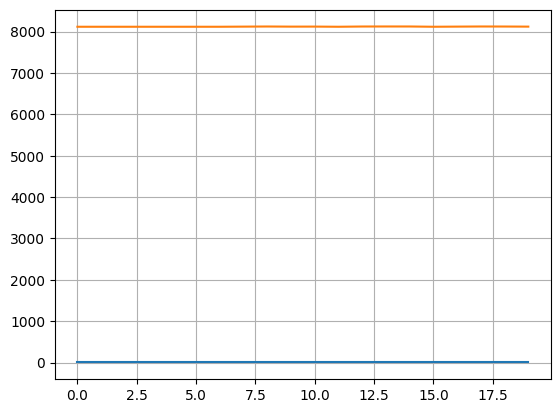

In [8]:
plt.plot(lst_loss_train)
plt.plot(lst_loss_val)
plt.grid()
plt.show()